In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import cm

In [2]:
"""Functions Used"""

#Energy Function
def Z(x, y, gamma):
    """
    Function to quickly calculate the energy of the given X, Y
    """
    z = 5 - 0.7 * np.log( (np.exp(-(x+2)**2 - (y+2)**2)/gamma) + (np.exp(-(x-2)**2 - (y-1)**2)/gamma) + (np.exp(-(x+3)**2 - 5*(y-2)**2)/gamma) + 0.003 * np.exp((x)**2 - (y+0.5)**2)/gamma + 0.04 * np.exp(-(x+0.1)**2 - (y-2)**2)/gamma)
    return z

#Get the energy of the given guesses
def fetch_energy_states(xx, yy, gamma):
    """
    Wrapper of the Z function to calculate energy on given states
    """
    energy = Z(xx, yy, gamma)
    
    return energy

#Generate data on the potential
def generate_data(Nimage, Nstep, beta, sigma, gamma, force, Xlastx, Xlasty, constrx_, constry_):
    """
    Function to generate data for the given number of images (Nimage), steps (Nstep), using 
    
    """

    #Initialize the data array
    data = np.zeros((Nimage, Nstep, 2))
    
    Elast = np.zeros(Nimage)
    for i in range(Nimage):
        bias = force[i]/2*((Xlastx[i]-constrx_[i])**2 + (Xlasty[i]-constry_[i])**2)
        Elast[i] = fetch_energy_states(Xlastx[i], Xlasty[i], gamma) + bias
    
    for j in range(Nstep):
        for i in range(Nimage):
            r = np.random.rand(1)
            b = np.random.rand(1)
            u = -np.log(r)
            rho = sigma*np.sqrt(2.0*u)
            theta = 2.0*np.pi*b
            xx = rho*np.cos(theta) + Xlastx[i]
            yy = rho*np.sin(theta) + Xlasty[i]
            bias = force[i]/2* ((xx-constrx_[i])**2 + (yy-constry_[i])**2)
            Ecurrent = bias + fetch_energy_states(xx, yy, gamma)
            
            if xx < -3 or xx > 3 or yy < -3 or yy > 3:
                Ecurrent=100000000
                
            fact = np.exp(-(Ecurrent-Elast[i]) * beta)
            rr = np.random.rand(1,1)
            
            if rr < fact:
                Xlastx[i]=xx
                Xlasty[i]=yy
                Elast[i]=Ecurrent
                data[i,j,0]=xx
                data[i,j,1]=yy
            else:
                data[i,j,0]=Xlastx[i]
                data[i,j,1]=Xlasty[i]
                
    return data, Xlastx, Xlasty


def optimize_string(data_avg):
    """
    Function to optimize the string data 
    """
    ndim = data_avg.shape[1]
    n = data_avg.shape[0]
    Nnew = n 

    X = np.arange(1, n+0.1, 0.1)
    norder = 6

    p = []
    for k in range(ndim):
        p.append(np.polyfit(np.arange(1, n+1), data_avg[:,k], deg=norder))

    Y = np.zeros(len(X))
    for j in range(ndim):
        Y = Y + (np.polyval(np.polyder(p[j]), X))**2

    Y = np.sqrt(Y)
    L = np.trapz(Y, X) #Careful with this, it is counterintuitive
    Li = np.linspace(0, L, Nnew)

    flen = np.zeros(len(X))
    for ibig in range(1, len(X)):
        flen[ibig] = np.trapz(Y[:ibig+1], X[:ibig+1]) #Careful with this, it is counterintuitive

    pt = np.zeros(Nnew).astype(int)
    for i in range(Nnew):
        idx = np.argmin(abs(flen-Li[i]))
        pt[i] = int(idx)

    G = np.zeros((ndim, len(X)))
    newconstr = []
    for j in range(ndim):
        G[j] = np.polyval(p[j], X)
        newconstr.append(G[j, pt])
    newconstr = np.array(newconstr)
        
    return newconstr

In [3]:
""" Constants """
Nstep = 1000 #Number of steps to run for
ngrid= 30 # Size of grid
Nimage = 30 # Number of images/windows
beta = 1/0.596
#KbT = 0.596 not used
sigma = 1 
gamma = 0.01
arb = 0.7


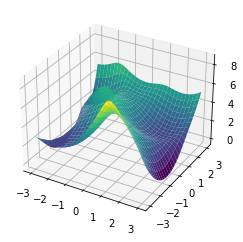

In [4]:
""" Plotting the potential surface """
#NOTE: uncomment "qt" for the 3D pop-up view, uncomment "inline" for the 2D notebook plot
#%matplotlib qt
%matplotlib inline

#Meshgrid of potential surface
[x,y] = np.meshgrid(np.linspace(-3, 3, ngrid), np.linspace(-3, 3, ngrid))

#Calculating Energy for each
z = Z(x, y, gamma)

#Plotting the potential Surface
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, z, cmap=plt.cm.viridis)

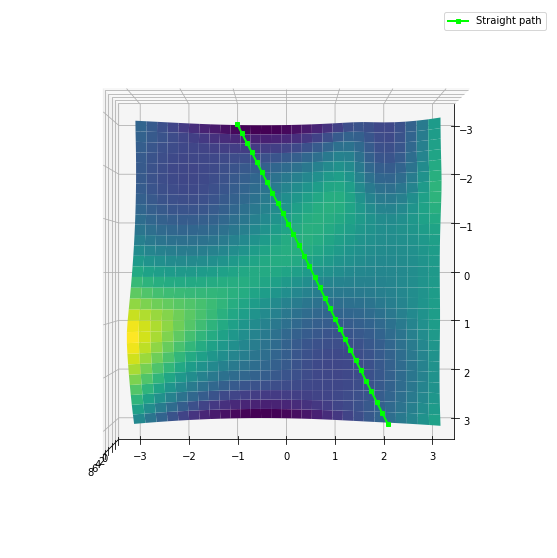

In [5]:
"""Getting straight line path"""
#NOTE: uncomment "qt" for the 3D pop-up view, uncomment "inline" for the 2D notebook plot
#%matplotlib qt
%matplotlib inline

#Setting up a straight path from (-3,-1) to (3,2)
constrx = np.linspace(-3,3, Nimage)
constry = np.linspace(-1,2, Nimage)
force = np.linspace(2,2, Nimage)

zval = np.zeros(Nimage)
for n in range(Nimage):
    zval[n] = fetch_energy_states(constrx[n], constry[n], gamma) + arb
    
#Now we plot it on top
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot(constrx, constry, zval, "-s", markersize=4, linewidth=2, color="lime", zorder=3, label="Straight path")
ax.plot_surface(x, y, z, cmap=plt.cm.viridis, zorder=1)
plt.legend()
ax.view_init(azim=0, elev=90)

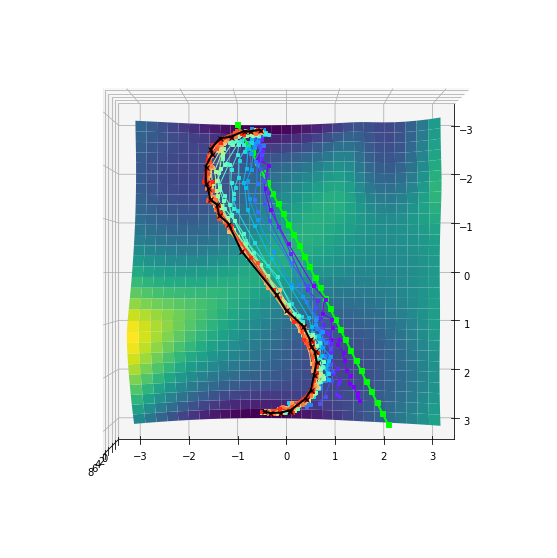

In [9]:
""" Sampling and optimizing the string """
#NOTE: uncomment "qt" for the 3D pop-up view, uncomment "inline" for the 2D notebook plot
#%matplotlib qt
%matplotlib inline

#Copying the original straight path
coord_lastx, coord_lasty = np.copy(constrx), np.copy(constry)
constrxx, constryy = np.copy(constrx), np.copy(constry)

#Generating base plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, z,cmap=plt.cm.viridis, zorder=1)
ax.plot(constrx, constry, zval, "-s", markersize=5, color="lime", linewidth=2, zorder=3, label="Original Path")

#Number of iterations to run for 
niter = 20
#Colors for the path lines
color = cm.rainbow(np.linspace(0, 1, niter))

for itr in range(niter):
    
    #Generate stochastic data 
    data, coord_lastx, coord_lasty = generate_data(Nimage, Nstep, beta,
                                                   sigma, gamma, force, coord_lastx,
                                                   coord_lasty, constrxx, constryy)
    current = np.zeros((Nimage, 2))
    
    #Evaluate energy 
    zval_c = np.zeros(Nimage)
    for i in range(Nimage):
        current[i] = np.mean(data[i], axis=0)
        zval_c[i] = fetch_energy_states(current[i][0], current[i][1], gamma) + arb
    
    #Plot the new path
    ax.plot(current.T[0], current.T[1], zval_c, "-s", markersize=3, linewidth=1,
            color=color[itr], zorder=10, label="Iter {}".format(itr+1))
    
    #Optimize the string for the next iteration
    constrxx, constryy = optimize_string(current)
    

#Evaluate for the last path
for i in range(Nimage):
    zval_c[i] = fetch_energy_states(current[i][0], current[i][1], gamma) + arb + 0.3

#Finishing the plot with the optimized path
ax.plot(current.T[0], current.T[1], zval_c, "-x", markersize=5,
        linewidth=2, color="black", zorder=10, label="Optimized Path")

#This for viewing from top
ax.view_init(azim=0, elev=90)
#Optional Legend
#plt.legend() 